In [ ]:
# # Install numpy
# !pip install numpy

# # Install pandas
# !pip install pandas

# # Install matplotlib
# !pip install matplotlib

# # Install seaborn
# !pip install seaborn

# # Install TensorFlow
# !pip install tensorflow

# # Install scikit-learn
# !pip install scikit-learn


In [18]:
# ### Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB0  # Correct import for EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Load and Inspect the Data
csv_file = r'C:\Users\nisha\Desktop\Projects\DiabeticRetinopathy\Dataset\messidor_data.csv'  # CSV file path
df = pd.read_csv(csv_file)

In [4]:
# Display the first few rows of the dataset
print(df.head())

                     image_id  adjudicated_dr_grade  adjudicated_dme  \
0  20051020_43808_0100_PP.png                   0.0              0.0   
1  20051020_43832_0100_PP.png                   1.0              0.0   
2  20051020_43882_0100_PP.png                   1.0              0.0   
3  20051020_43906_0100_PP.png                   2.0              1.0   
4  20051020_44261_0100_PP.png                   0.0              0.0   

   adjudicated_gradable  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  


In [5]:
# Filter out ungradable images
df = df[df['adjudicated_gradable'] == 1]

# Drop the 'adjudicated_gradable' column as it's not needed anymore
df = df.drop(columns=['adjudicated_gradable'])

In [6]:
# Convert the 'adjudicated_dr_grade' column to string
df['adjudicated_dr_grade'] = df['adjudicated_dr_grade'].astype(str)

In [7]:
# Display the class distribution of DR and DME
print("Distribution of DR grades:")
print(df['adjudicated_dr_grade'].value_counts())
print("Distribution of DME grades:")
print(df['adjudicated_dme'].value_counts())

Distribution of DR grades:
adjudicated_dr_grade
0.0    1017
2.0     347
1.0     270
3.0      75
4.0      35
Name: count, dtype: int64
Distribution of DME grades:
adjudicated_dme
0.0    1593
1.0     151
Name: count, dtype: int64


In [8]:
# Determine the number of unique classes for the target variable
num_classes = df['adjudicated_dr_grade'].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 5


In [9]:
# Prepare the image data generator
image_dir = r'C:\Users\nisha\Desktop\Projects\DiabeticRetinopathy\Images'  # Update this to your actual image directory path
img_height, img_width = 224, 224
batch_size = 32

In [10]:
# Data generator with augmentation options
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,     # Rotate the images randomly
    width_shift_range=0.2, # Shift the image width-wise
    height_shift_range=0.2,# Shift the image height-wise
    shear_range=0.2,       # Apply shear transformation
    zoom_range=0.2,        # Randomly zoom into images
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True     # Flip images vertically (if applicable)
)

In [11]:
# Data generator for training
train_generator = data_gen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='image_id',
    y_col='adjudicated_dr_grade',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 1396 validated image filenames belonging to 5 classes.


In [23]:
# Data generator for training
train_generator = data_gen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='image_id',
    y_col='adjudicated_dr_grade',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 1396 validated image filenames belonging to 5 classes.


In [12]:
# Data generator for validation
validation_generator = data_gen.flow_from_dataframe(
    dataframe=df,
    directory=image_dir,
    x_col='image_id',
    y_col='adjudicated_dr_grade',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 348 validated image filenames belonging to 5 classes.


In [16]:
# ### Build the Model Using an Ensemble of Advanced Pre-trained Models
# Changes start here

# Define the input tensor
input_tensor = Input(shape=(img_height, img_width, 3))

In [19]:
# EfficientNetB0 base model
base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model1.trainable = False

In [20]:
# InceptionV3 base model
base_model2 = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 45s 1us/step


In [21]:
# VGG16 base model
base_model3 = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3.trainable = False

In [22]:
# Extract features from each base model
x1 = base_model1.output
x2 = base_model2.output
x3 = base_model3.output

In [23]:
# Pool the extracted features
x1 = GlobalAveragePooling2D()(x1)
x2 = GlobalAveragePooling2D()(x2)
x3 = GlobalAveragePooling2D()(x3)

In [24]:
# Concatenate the features from different models
concatenated = Concatenate()([x1, x2, x3])

In [25]:
# Add custom dense layers
x = Dense(1024, activation='relu')(concatenated)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [26]:
# Define the ensemble model
ensemble_model = Model(inputs=input_tensor, outputs=predictions)

In [27]:
# Compile the ensemble model
ensemble_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# ### Train the Model
epochs = 20

history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/20


C:\Users\nisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.4992 - loss: 1.4092 - val_accuracy: 0.5375 - val_loss: 1.1710
Epoch 2/20
 1/43 ━━━━━━━━━━━━━━━━━━━━ 1:45 3s/step - accuracy: 0.5625 - loss: 1.1275

C:\Users\nisha\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5625 - loss: 1.1275 - val_accuracy: 0.6071 - val_loss: 1.1996
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.5735 - loss: 1.1231 - val_accuracy: 0.5375 - val_loss: 1.1920
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6250 - loss: 1.0328 - val_accuracy: 0.4643 - val_loss: 1.2776
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.5925 - loss: 1.0584 - val_accuracy: 0.5469 - val_loss: 1.1637
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6875 - loss: 0.9097 - val_accuracy: 0.3929 - val_loss: 1.3761
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.5708 - loss: 1.1137 - val_accuracy: 0.5594 - val_loss: 1.1399
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6875 - loss: 0.8774 - val_accuracy: 0.5714 - val_loss: 1.1762
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.5972 - loss: 1.0549 - val_accuracy: 0.5500 - val_loss: 1.

In [29]:
# ### Evaluate the Model
val_loss, val_accuracy = ensemble_model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.5501 - loss: 1.1405
Validation Loss: 1.164863109588623
Validation Accuracy: 0.5517241358757019


In [30]:
# ### Confusion Matrix and Classification Report
validation_generator.reset()
preds = ensemble_model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = validation_generator.classes[:len(y_pred)]

11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step


In [31]:
print("Confusion Matrix")
cm = confusion_matrix(y_true, y_pred)
print(cm)

Confusion Matrix
[[142   0  38   4   0]
 [ 48   0   7   2   0]
 [ 70   0  10   2   0]
 [ 10   0   5   0   0]
 [  7   0   2   1   0]]


In [32]:
print("Classification Report")
cr = classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)])
print(cr)

Classification Report
              precision    recall  f1-score   support

           0       0.51      0.77      0.62       184
           1       0.00      0.00      0.00        57
           2       0.16      0.12      0.14        82
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        10

    accuracy                           0.44       348
   macro avg       0.13      0.18      0.15       348
weighted avg       0.31      0.44      0.36       348



C:\Users\nisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

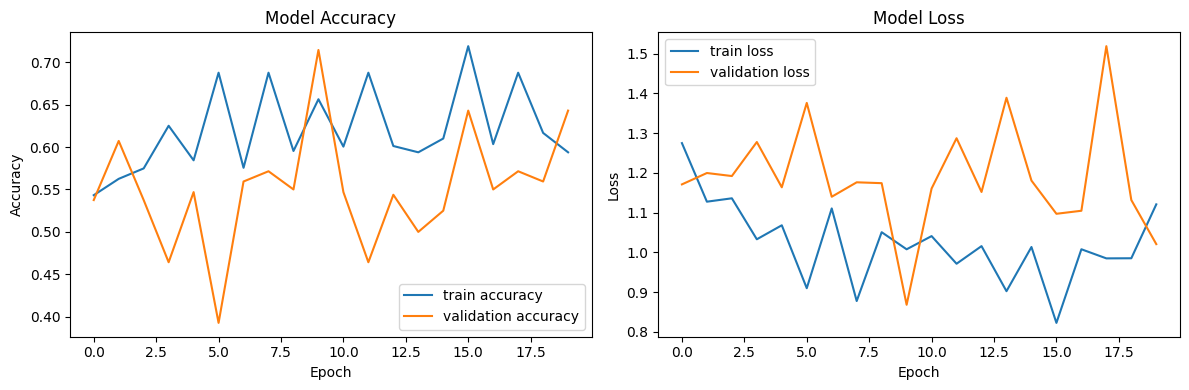

In [33]:
# ### Plotting Training History
def plot_history(history):
    # Plot accuracy and loss over epochs
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot training & validation accuracy
    ax[0].plot(history.history['accuracy'], label='train accuracy')
    ax[0].plot(history.history['val_accuracy'], label='validation accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='best')
    
    # Plot training & validation loss
    ax[1].plot(history.history['loss'], label='train loss')
    ax[1].plot(history.history['val_loss'], label='validation loss')
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()

plot_history(history)